In [462]:
#pip install qiskit pylatexenc

In [463]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import UnitaryGate

from qiskit.quantum_info import Statevector, Operator
import pylatexenc

import matplotlib.pyplot as plt

import numpy as np

# Mini-project 2

**Author: Lara Ismert**

**Date: June 16, 2025**

In this project, we will implement the oracle $U_a$ which is implemented in the order-finding part of Shor's algorithm.

Fix $a,N\in \mathbb{Z}_+$ such that $a< N$, and set $n:=2 \lceil \log_2(N) \rceil.$  Write a Qiskit function which outputs the oracle $U_a$ such that for all $\ket{y}_n$:
$$
    U_a\ket{x}_1\ket{y}_n
    =
    \begin{cases}
    \ket{x}_1 \ket{ay \mod N}_n \quad \text{if }x=1 \\
    \ket{x}_1\ket{y}_n \quad \text{otherwise}
    \end{cases}
$$

The construction may only use 1-qubit gates, multi-controlled phase and X gates with any number of controls, and the built-in version of the Quantum Fourier Transform (and its inverse). No classical bit and measurements allowed.

This oracle is the only "quantum" part of Shor's algorithm to find a factor of $N$. In particular, Shor's original paper gives a reduction of the factoring problem to the **order-finding problem**, wherein we seek to find $r\in \mathbb{N}$ such that $a^r \equiv 1\mod N$, assuming $gcd(a,N)=1$ (otherwise, the Euclidean algorithm for computing $gcd(a,N)$ will provide a nontrivial factor of $N$).

Notice that the order $r$ of the group element $a\mod N$ also satisfies $U_a^r\ket{x}_1\ket{1}_n = \ket{x}_1\ket{1}_n$ for all $x\in \mathbb{F}_2$. Finding $r$ can be done using the following circuit:

In [464]:
# Input the standard matrix rep of your desired single-qubit unitary

matrix_U = [[0, 1], [-1, 0]] 

# Make U into a gate by applying UnitaryGate to the matrix U

U_gate = UnitaryGate(matrix_U)


Below is a controlled $U_a$ gate.

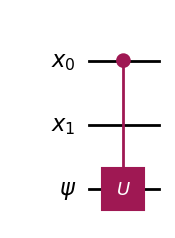

In [465]:
n = 2

qr = QuantumRegister(size=n, name="x")
ar = AncillaRegister(size=1,name = r"\psi")

U_circuit = QuantumCircuit(ar,name = "$U$")
U_circuit.append(U_gate,ar)

controlled_U_gate = U_circuit.to_gate().control(1)
 
controlled_U_circuit = QuantumCircuit(qr,ar)
controlled_U_circuit.append(controlled_U_gate, [0, -1])
controlled_U_circuit.draw('mpl')

Let $U\in \mathcal{U}(2)$ be given, and let $U^m$ denote the $m$-fold matrix product of $U$ with itself. For Quantum Phase Estimation, we will have controlled $U^m$ gates for $m=2^k$ for $k=0,\dots,n-1$ with control on the $(n-1-k)^{th}$ qubit, where $n$ denotes the total number of qubits needed for our desired precision (excluding the target qubit, $\ket{\psi}$).

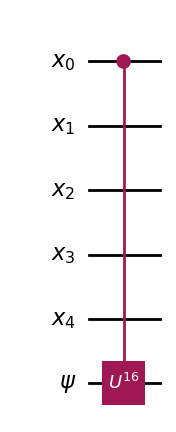

In [466]:
#

def power_gate(U,m):
    power_U_gate = UnitaryGate(np.linalg.matrix_power(matrix_U, m))
    return power_U_gate 

# controlled_power_gate produces a controlled - U^{2^k} gate
# with control qubit n-1-k and target qubit -1 (bottom)

def controlled_power_gate(U,k,n):
    m = 2**k # Only the first digit is superscripted :(
    qr = QuantumRegister(size=n, name="x")
    ar = AncillaRegister(size=1,name = r"\psi")
    power_U_circuit = QuantumCircuit(ar,name = f"$U^{{{m}}}$")
    power_U_circuit.append(power_gate(U,m),ar)

    controlled_power_U_gate = power_U_circuit.to_gate().control(1)
    controlled_power_U_circuit = QuantumCircuit(qr,ar)
    controlled_power_U_circuit.append(controlled_power_U_gate, [n-1-k, -1])

    return controlled_power_U_circuit

U = [[0,1],[1,0]]   

controlled_power_gate(U,4,5).draw('mpl')

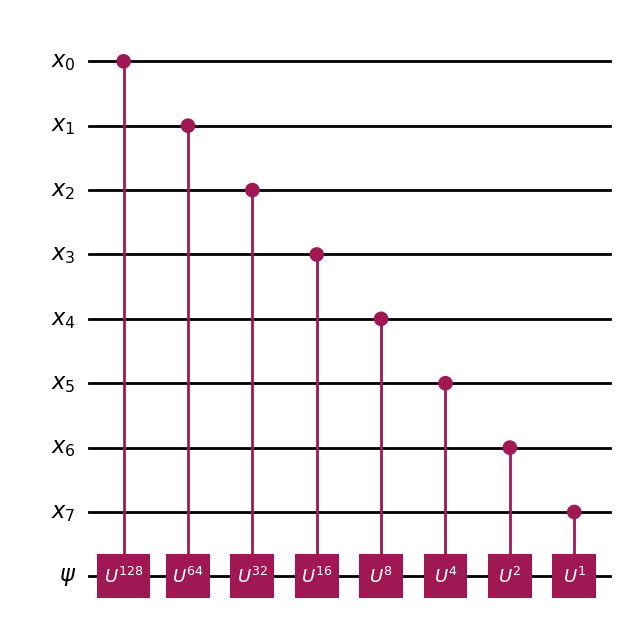

In [467]:
n = 8
U = [[0,-1],[1,0]]

qr = QuantumRegister(size=n, name="x")
ar = AncillaRegister(size=1,name = r"\psi")
U_phase_circuit = QuantumCircuit(qr,ar)

for k in reversed(range(0,n)): 
    U_phase_circuit.compose(controlled_power_gate(U,k,n), inplace = True)
    #U_phase_circuit.append(power_gate) 

U_phase_circuit.draw('mpl')


The algorithm we employ for order-finding also requires the $QFT$ and $QFT^\dagger$.

In [468]:
# I have borrowed code from the QC Bootcamp 2 Problem Session notebook.

def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name="QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=r"$QFT^{\dagger}$")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

# Implementing the oracle $U_a$

Our main source for implementing this oracle comes from St&eacute;phane Beauregard's 2003 article __[**Circuit for Shor’s algorithm using $2n+3$ qubits**](https://arxiv.org/pdf/quant-ph/0205095)__. Note that the number of qubits needed to implement Beauregard's circuit, $2n+3$, does not depend on the size of the integer $N$, to be factored. Similarly, the circuit requires $\mathcal{O}(n^3 \log(n))$ elementary quantum gates with a depth of $\mathcal{O}(n^3)$.

We will implement $U_a\ket{x}_1\ket{y}_n = \ket{x}_1\ket{ay \mod N}_n$ following Beauregard's deconstruction of $U_a$ into three main steps.

1. The $\phi ADD(a)$ gate, which is the conjugation of the Draper adder gate $ADD(a)$ by the QFT, applied to $QFT\ket{b}_n$.

2. Once we have the $\phi ADD(a)$ gate, we can build the $\phi ADD(a) \mod N$, which determines when the image $\phi ADD(a)\ket{\phi(b)}_n = \ket{\phi(a+b)}_N$ needs to subtract $N$ in order to be within $\{0,\dots, N-1\}$. This circuit requires:

- *three* doubly-controlled $\phi ADD(a)$ / $\phi MINUS(a)$ gates.

- *two* applications of both $QFT^\dagger$ and $QFT$, 

- *one* controlled-$\phi ADD(N)$ gate and two controlled-NOT gates, and

- *two* NOT gates.

3. Nearly there, we build $MULT(a)MOD(N)$, which includes 
- $k$ iterations of singly-controlled $\phi ADD(2^k a)MOD(N)$ gates, and 

- both the $QFT$ and $QFT^\dagger$.

4. Last, we construct $C-MULT(a)MOD(N)$ to the original register with one additional qubit to serve as the control.


## Step 1: $\phi ADD(a)$

We first implement the unitary gate $\phi ADD(a)$, which is basically Draper's adder gate for $a\in \mathbb{N}$ and satisfies the following: for $b\in \mathbb{F}^n_2$:
$$
\phi ADD(a)(QFT\ket{b}_n)
=
QFT\ket{a+b}_n.
$$

Precisely, $\phi ADD(a)$ is the conjugate of Draper's adder $ADD(a)$ by the QFT:
$$
\phi ADD(a)(QFT\ket{b}_n)
=
QFT \circ ADD(a) \circ QFT^\dagger (QFT\ket{b}_n)
=
QFT \ket{a+b}_n.
$$

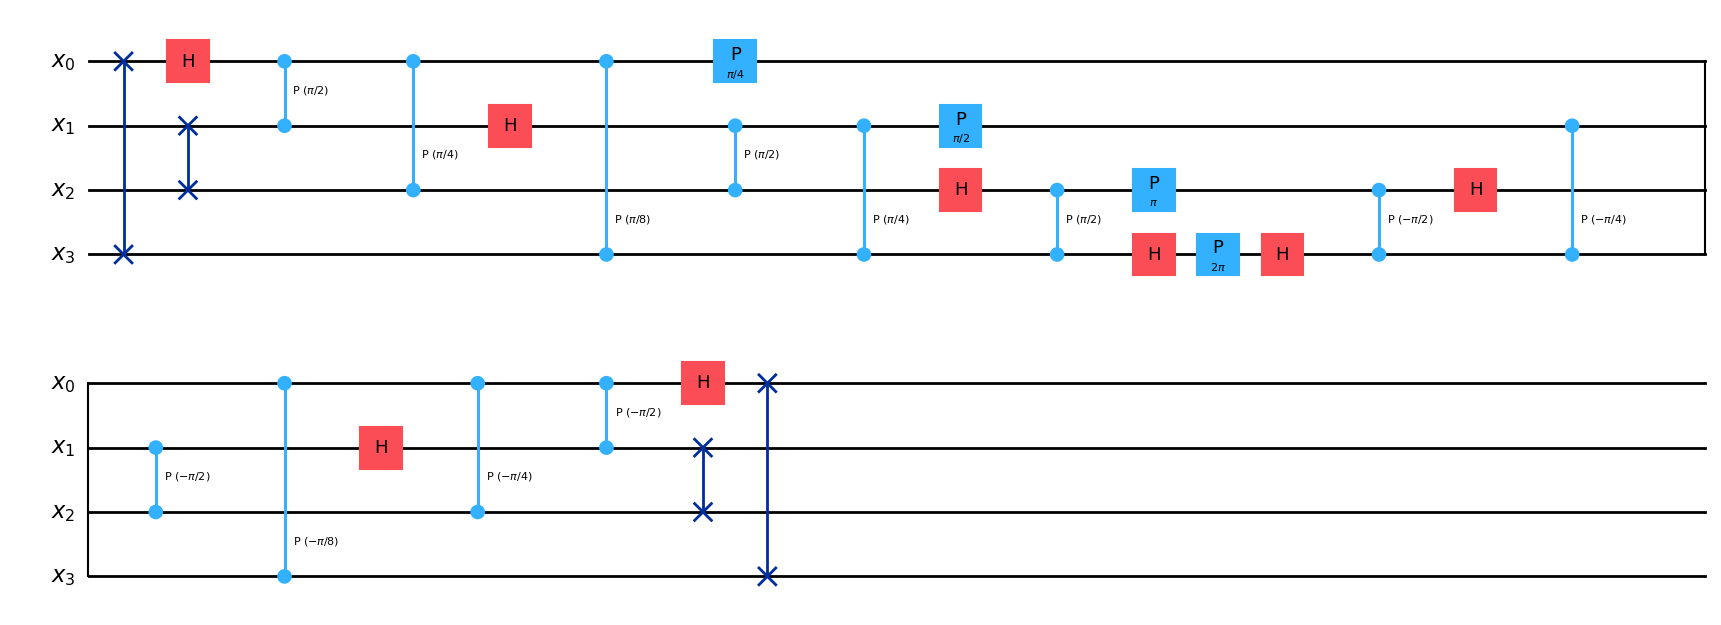

In [469]:
# This code was borrowed from the QC Bootcamp 2 Problem Session. 

# Below is Draper's adder ADD(a) for a a nonnegative integer between 0 and n-1.

def quantum_adder(a, n):
    quantum_register = QuantumRegister(size=n, name="x")
    quantum_adder_circuit = QuantumCircuit(quantum_register, name=f"ADD({a})")
    
    quantum_adder_circuit.compose(quantum_fourier_transform(n), inplace=True)

    #quantum_adder_circuit.barrier()
    
    # phaser part
    for idx, q in enumerate(reversed(quantum_register)):
        quantum_adder_circuit.p(np.pi * a / (1 << idx), q)
    
    #quantum_adder_circuit.barrier()
    
    quantum_adder_circuit.compose(inverse_quantum_fourier_transform(n), inplace=True)
    
    return quantum_adder_circuit

quantum_adder(2,4).draw('mpl')


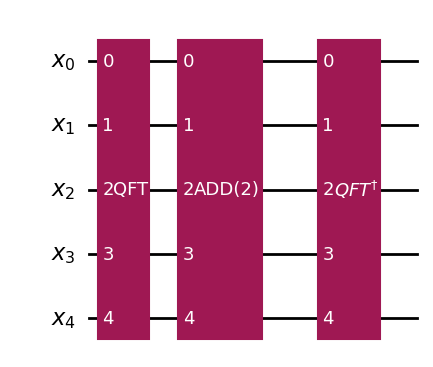

In [470]:
def phiADD(a,n):
    qr = QuantumRegister(size=n, name="x")
    phi_adder_circuit = QuantumCircuit(qr, name=f"$\\phi$ ADD({a})")
    
    phi_adder_circuit.append(quantum_fourier_transform(n),qr)
    phi_adder_circuit.append(quantum_adder(a,n),qr)
    phi_adder_circuit.append(inverse_quantum_fourier_transform(n), qr)

    return phi_adder_circuit

phiADD(2,5).draw('mpl')

## Step 2: $\phi ADD(a)\mod N$

We begin by creating four functions which will produce single-controlled and double-controlled $\phi ADD$ and $\phi ADD^\dagger$ gates.

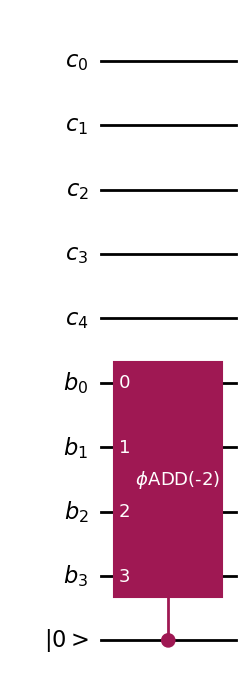

In [471]:
def CphiAdd(N,n):

    # Registers
    
    cr = AncillaRegister(n+1,'c')
    qr = QuantumRegister(n, 'b')
    ar = QuantumRegister(1,'|0>')

    # Main circuit

    C_phiAdd_circuit = QuantumCircuit(cr,qr,ar, name = 'C_phi_ADD')

    # Base circuit 
    qc = QuantumCircuit(qr, name = f'$\\phi$ADD({a})')
    qc.compose(phiADD(N,n),qr)

    # Singly controlled base circuit
    c_append = qc.to_gate().control(1)
    tbits = list(range(n+1,2*n+1))
    cbit = [-1]
    C_phiAdd_circuit.append(c_append, cbit + tbits)

    #return qc
    return C_phiAdd_circuit

def CphiSubtract(N,n):
    cr = AncillaRegister(n+1,'c')
    qr = QuantumRegister(n, 'b')
    ar = QuantumRegister(1,'|0>')
    
    C_phiMinus_circuit = QuantumCircuit(cr,qr,ar, name = 'C_phi_MINUS')

    # Base circuit 
    qc = QuantumCircuit(qr, name = f' $\\phi$ADD({-a})')
    qc.compose(phiADD(N,n).inverse(),inplace = True)

    # Doubly controlled base circuit
    c_append = qc.to_gate().control(1)
    tbits = list(range(n+1,2*n+1))
    cbit = [-1]
    C_phiMinus_circuit.append(c_append, cbit + tbits)
    
    return C_phiMinus_circuit

CphiSubtract(2,4).draw('mpl')

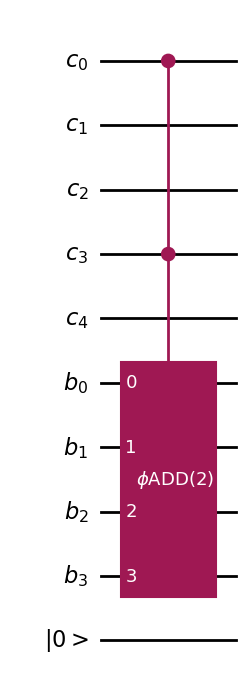

In [472]:
def CCphiAdd(a,n,x):
    cr = AncillaRegister(n+1,'c')
    qr = QuantumRegister(n, 'b')
    ar = AncillaRegister(1, '|0>')
    
    CC_phiAdd_circuit = QuantumCircuit(cr,qr,ar, name = 'CC_phi_ADD')

    # Base circuit 
    qc = QuantumCircuit(qr, name = f'$\\phi$ADD({a})')
    qc.compose(phiADD(a,n),qr)

    # Doubly controlled base circuit
    cc_append = qc.to_gate().control(2)
    tbits = list(range(n+1,2*n+1))
    cbits = [0,x]
    CC_phiAdd_circuit.append(cc_append, cbits + tbits)

    #return qc
    return CC_phiAdd_circuit

def CCphiSubtract(a,n,x):
    cr = AncillaRegister(n+1,'c')
    qr = QuantumRegister(n, 'b')
    ar = AncillaRegister(1, '|0>')
    CC_phiMinus_circuit = QuantumCircuit(cr,qr,ar, name = 'CC_phi_MINUS')

    # Base circuit 
    qc = QuantumCircuit(qr, name = f' $\\phi$ADD({-a})')
    qc.compose(phiADD(a,n).inverse(),inplace = True)

    # Doubly controlled base circuit
    cc_append = qc.to_gate().control(2)
    tbits = list(range(n+1,2*n+1))
    cbits = [0,x]
    CC_phiMinus_circuit.append(cc_append, cbits + tbits)
    
    return CC_phiMinus_circuit

CCphiAdd(2,4,3).draw('mpl')

**The single overflow ancilla qubit**

Now is a reasonable place to discuss the extra register at the bottom of our C-$\phi$ adder/subtractor functions defined above and at the bottom of our register for the full $\phi ADD(a)\mod N$ circuit below. Note that the C- functions only ever depend on $N$. These singly-controlled gates are checking whether or not adding $a$ to $b$ "overflowed" the binary allotment for $N$. If overflow has occurred, for example, $N=10$, $a=9$, and $b=8$, then because $10$ in binary (1010) requires $n=4$ bits, but $a+b$ in binary (10001) requires 5 bits, the overflow qubit at in the bottom of the register will detect this overflow. 

Notes:
1. I am not sure how exactly this works, but when the number of bits required is exceeded, the "overflow" qubit at the bottom will be "turned on." 
2. I am not sure how this idea of overflow would detect a sum like $a=9$ and $b=6$, where $a+b$ in binary is 1111 and does not "overflow" and require another bit.

**The two control qubits**

To construct C-$MULT(a) \mod N$, we will need to apply CC-$\phi ADD(2^k\cdot a)\mod N$ for $k=0,\dots, n-1$, where $n$ is the length of $N$ in binary. Thus, we introduced the ancilla register cr, or control_register (below), containing precisely two qubits. 

In [473]:
# If N is the composite number we wish to factor,
# Shor's algorithm computes the order mod N of a 
# random number $a$ chosen between 2 and N-1

import random

N = 20

# We need the same number of qubits as the length of N in binary
# We have to subtract 2 (see string printed below that starts with 0b

n = len(bin(N)) - 2 

# Now we'll randomly generate a representative "a" in Z_N 
# whose order Shor's algorithm is designed to compute 

a = random.randint(2,N-1)

# Let's see what we're working with

print([bin(N),a,n])

['0b10100', 18, 5]


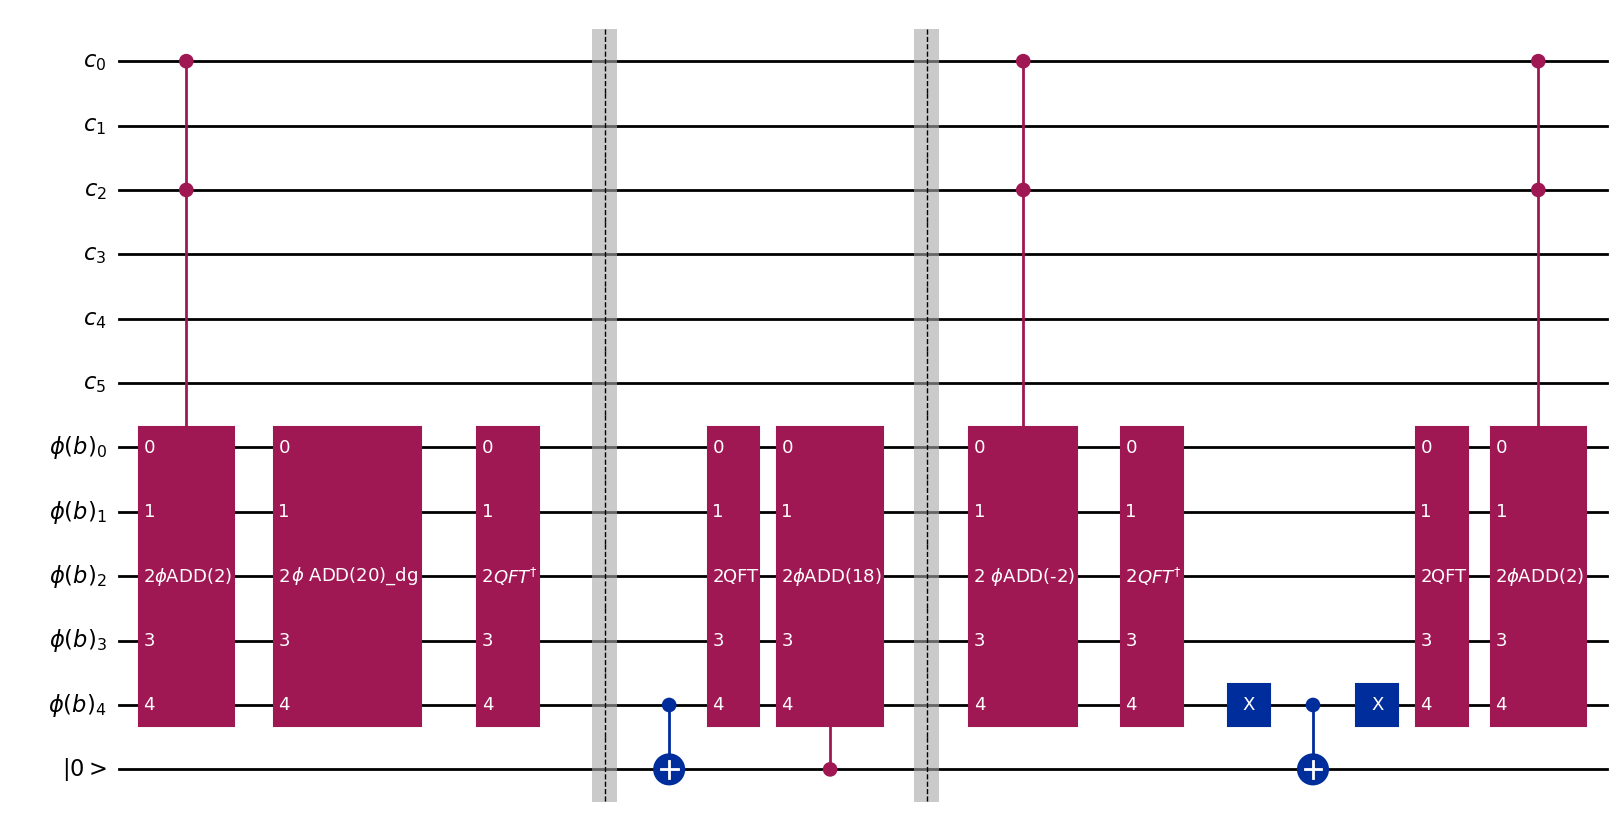

In [474]:
# Suppose we want to find the order of a in Z_N.

def CCphiAddMod(a,n,x):

    control_register = AncillaRegister(n+1,'c')
    quantum_register = QuantumRegister(n, name = r'\phi(b)')
    overflow_register = QuantumRegister(1,'|0>')

    Add_mod_N_circuit = QuantumCircuit(control_register,quantum_register,overflow_register,name = f'$\\phi ADD({a}) mod N$')

## THE REAL WORK PART - let's pre-emptively assume a+b > N-1

    Add_mod_N_circuit.compose(CCphiAdd(a,n,x),inplace = True)

    # We now pre-emptively subtract N in case there was overflow

    Add_mod_N_circuit.append(phiADD(N,n).inverse(), quantum_register) 

    # Then we undo the original application of the QFT to | b >

    Add_mod_N_circuit.append(inverse_quantum_fourier_transform(n),quantum_register)

    Add_mod_N_circuit.barrier() # Our state is now | a + b - N >

    # If there was overflow, i.e., a + b > N - 1, then a + b - N > -1.
    # Thus, our choice to pre-emptively subtract N was a good one!
    # We can tell if a + b - N > - 1 by the CNOT gate applied to the 
    # most significant bit (the final qubit in the main register)

    Add_mod_N_circuit.cx(quantum_register[-1],overflow_register[-1])

    # If the most significant bit is a 1, we then apply a controlled 
    # phi ADD(N) gate to add back N if we shouldn't have done it
    # in the first place. 

    Add_mod_N_circuit.append(quantum_fourier_transform(n),quantum_register)
    Add_mod_N_circuit.compose(CphiAdd(N,n), inplace= True)

    Add_mod_N_circuit.barrier()

# THE TEDIOUS WORK - PUTTING THE OVERFLOW QUBIT BACK TO |0>

    Add_mod_N_circuit.compose(CCphiSubtract(a,n,x), inplace=True)
    Add_mod_N_circuit.append(inverse_quantum_fourier_transform(n),quantum_register)
    Add_mod_N_circuit.x(quantum_register[-1])
    Add_mod_N_circuit.cx(quantum_register[-1],overflow_register[-1])
    Add_mod_N_circuit.x(quantum_register[-1])
    Add_mod_N_circuit.append(quantum_fourier_transform(n),quantum_register)
    Add_mod_N_circuit.compose(CCphiAdd(a,n,x),inplace = True)

    return Add_mod_N_circuit

CCphiAddMod(2,5,2).draw('mpl')

We can check mathematically that the above circuit is precisely the CC-$\phi ADD(a)\mod N$ circuit. Some of the preceding discussion described how the first two sections of the circuit pictured above would suffice if there was "overflow" past $N$, but the third and fourth sections are needed if there was no overflow and we then need to put the ancilla qubit back to |0> and undo our pre-emptive subtraction of $N$.

# Step 3: C-$MULT(a)\mod N$

Here it is, my attempt at implementing the modular multiplication circuit.

In [475]:
N = 15

n = len(bin(N)) - 2 

# Now we'll randomly generate a representative "a" in Z_N 
# whose order Shor's algorithm is designed to compute 

a = random.randint(2,N-1)

# Let's see what we're working with

print([bin(N),a,n])

['0b1111', 3, 4]


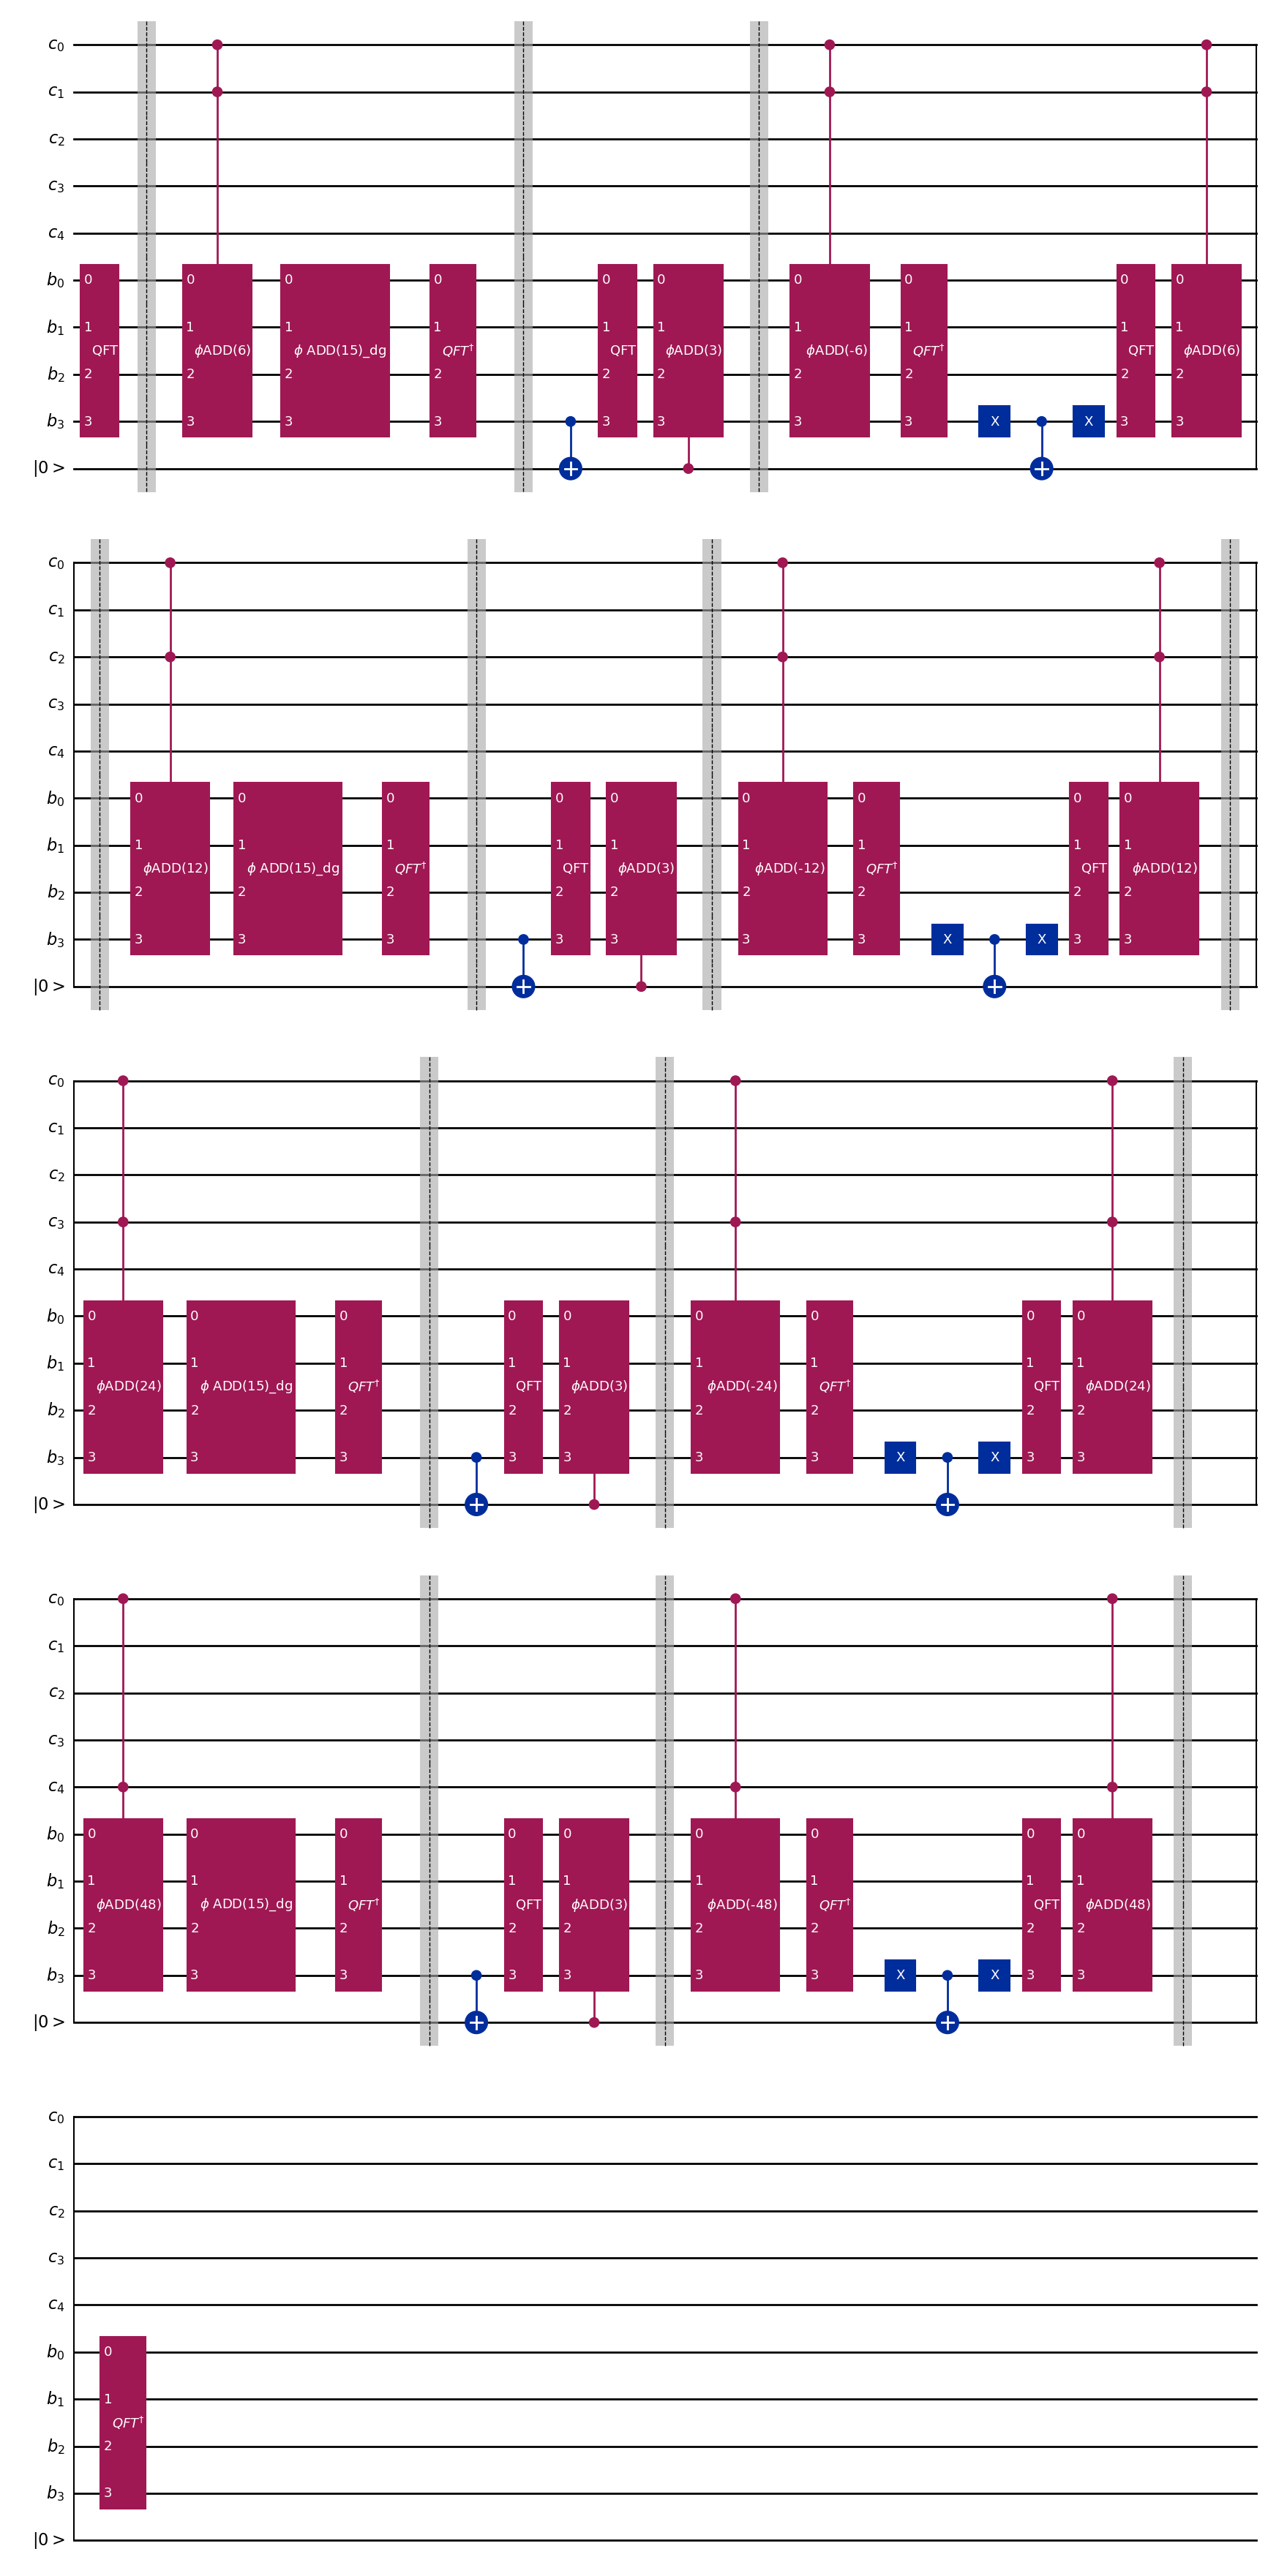

In [476]:
cr = AncillaRegister(n+1,'c')
qr = QuantumRegister(n,'b')
overflow_register = AncillaRegister(1,'|0>')

modular_multiplication_circuit = QuantumCircuit(cr,qr,overflow_register)

modular_multiplication_circuit.append(quantum_fourier_transform(n),qr)

modular_multiplication_circuit.barrier()


for j in range(1,n+1):
    k = 2**j*a
    modular_multiplication_circuit.compose(CCphiAddMod(k,n,j), inplace = True)
    modular_multiplication_circuit.barrier()    

modular_multiplication_circuit.append(inverse_quantum_fourier_transform(n),qr)

mm_inverse = modular_multiplication_circuit.inverse()

modular_multiplication_circuit.draw('mpl')

The $\ket{c_0}$ qubit acts as the single control qubit for C-$MULT(a)\mod N$, given by the circuit above for $N=15$ and some random $a\in \{2,\dots, N-1\}$.

# Step 4: Finally... $U_a$

Last we need to implement Figure 7 from Beauregard. 

In [477]:
# I used AI to generate this code quickly 

def gcd(a, b):
    if a == 0:
        return b, 0, 1
    else:
        gcd, x, y = gcd(b % a, a)
        return gcd, y - (b // a) * x, x

def inverse(a, N):
    gcd, x, _ = gcd(a, N)
    if gcd != 1:
        raise Exception('The modular inverse does not exist.')
    else:
        return x % N

# Example usage
print(f"The multiplicative inverse of {a} mod {n} is inverse(a, N)") # Output: The multiplicative inverse of 7 mod 26 is 15

The multiplicative inverse of 3 mod 4 is inverse(a, N)


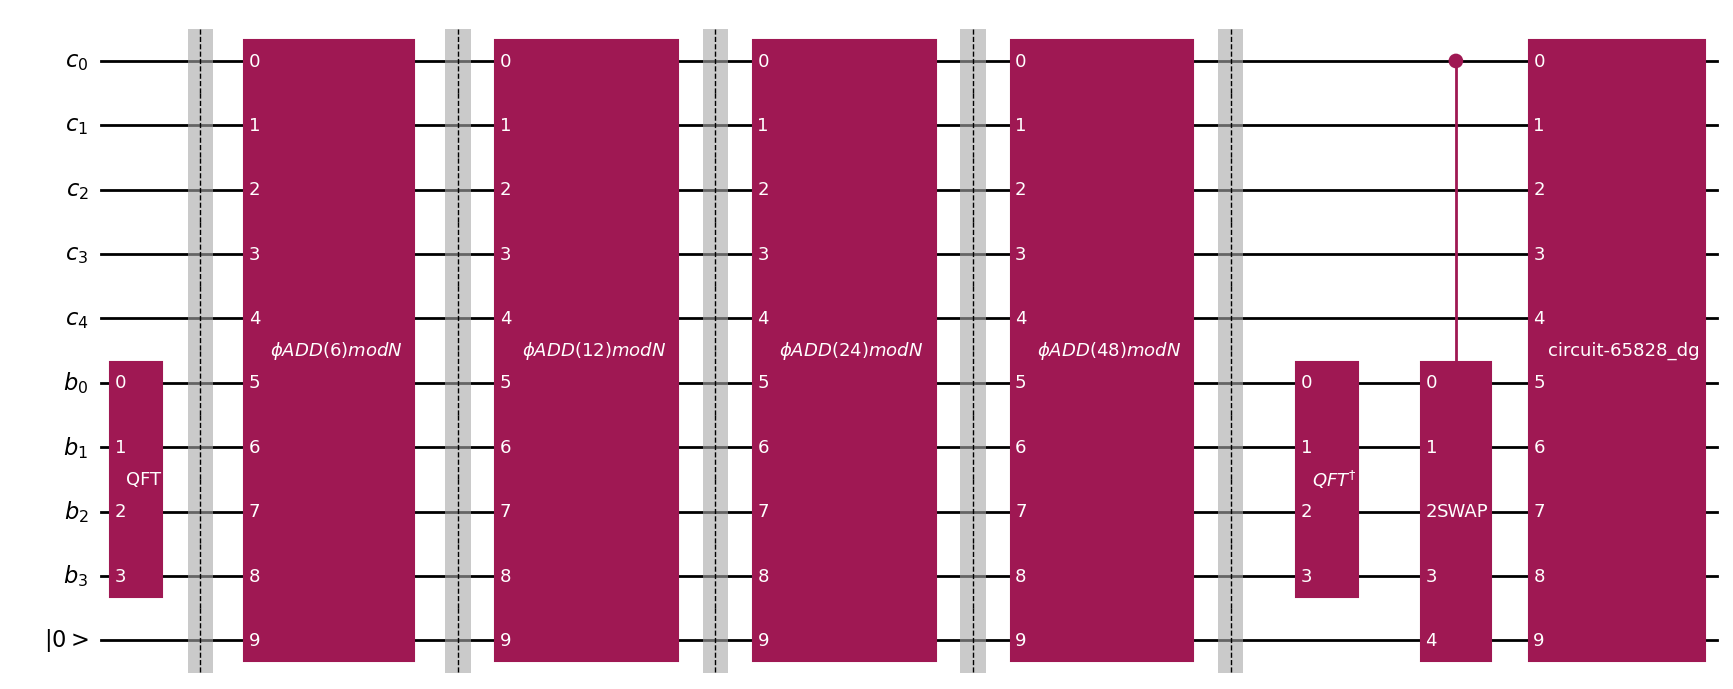

In [478]:
cr = AncillaRegister(n+1,'c')
qr = QuantumRegister(n,'b')
overflow_register = AncillaRegister(1,'|0>')

### Here is our mult mod circuit again

controlled_U_circuit = QuantumCircuit(cr,qr,overflow_register)

controlled_U_circuit.append(quantum_fourier_transform(n),qr)

controlled_U_circuit.barrier()

for j in range(1,n+1):
    k = 2**j*a
    controlled_U_circuit.append(CCphiAddMod(k,n,j), range(0,2*n+2))
    controlled_U_circuit.barrier()

controlled_U_circuit.append(inverse_quantum_fourier_transform(n),qr)


### Now we'll implement Figure 7 from Beauregard to obtain the C-U_a gate.

# Controlled-SWAP gate

qc = QuantumCircuit(qr,overflow_register, name = 'SWAP')
qc.swap(qr[0],overflow_register[0])
append = qc.to_gate().control(1)

###
cbit = [0]
tbits = list(range(n+1,2*n+2))
controlled_U_circuit.append(append,cbit + tbits)

## This is applying mult(a^{-1})(mod N)
controlled_U_circuit.append(modular_multiplication_circuit.inverse(), range(0,2*n+2))


controlled_U_circuit.draw('mpl')